In [ ]:
# Pseudo code
###### REMEMBER: the purpose of this script is to replace OpenFOAM writing of each sample plane, not to interpolate or write fields
# write RANS fields (probably done outside script)
# import RANS data
# for Re_theta_i:
#     find RANS vertical line location to match Re_theta_i
#     select RANS data along vertical line
#     dimensionalize DNS data using tau_w
#     compute DNS gradients in python (central difference scheme)
#     save DNS and RANS data

Assembled full foam field list: 
['k', 'omega', 'epsilon', 'T_t_ke', 'T_t_nut', 'T_k', 'U', 'gradp', 'gradk', 'gradomega', 'p', 'DUDt', 'wallDistance', 'nut', 'S', 'Shat', 'R', 'Rhat', 'Ap', 'Ak', 'Aphat', 'Akhat', 'gradU', 'skewness', 'C', 'I1_1', 'I2_1', 'I1_2', 'I2_2', 'I1_3', 'I2_3', 'I1_4', 'I2_4', 'I1_5', 'I2_5', 'I1_6', 'I2_6', 'I1_7', 'I2_7', 'I1_8', 'I2_8', 'I1_9', 'I2_9', 'I1_10', 'I2_10', 'I1_11', 'I2_11', 'I1_12', 'I2_12', 'I1_13', 'I2_13', 'I1_14', 'I2_14', 'I1_15', 'I2_15', 'I1_16', 'I2_16', 'I1_17', 'I2_17', 'I1_18', 'I2_18', 'I1_19', 'I2_19', 'I1_20', 'I2_20', 'I1_21', 'I2_21', 'I1_22', 'I2_22', 'I1_23', 'I2_23', 'I1_24', 'I2_24', 'I1_25', 'I2_25', 'I1_26', 'I2_26', 'I1_27', 'I2_27', 'I1_28', 'I2_28', 'I1_29', 'I2_29', 'I1_30', 'I2_30', 'I1_31', 'I2_31', 'I1_32', 'I2_32', 'I1_33', 'I2_33', 'I1_34', 'I2_34', 'I1_35', 'I2_35', 'I1_36', 'I2_36', 'I1_37', 'I2_37', 'I1_38', 'I2_38', 'I1_39', 'I2_39', 'I1_40', 'I2_40', 'I1_41', 'I2_41', 'I1_42', 'I2_42', 'I1_43', 'I2_43', 'I1

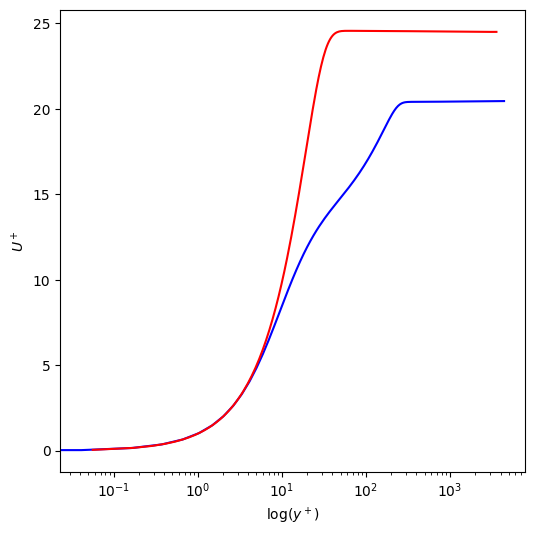

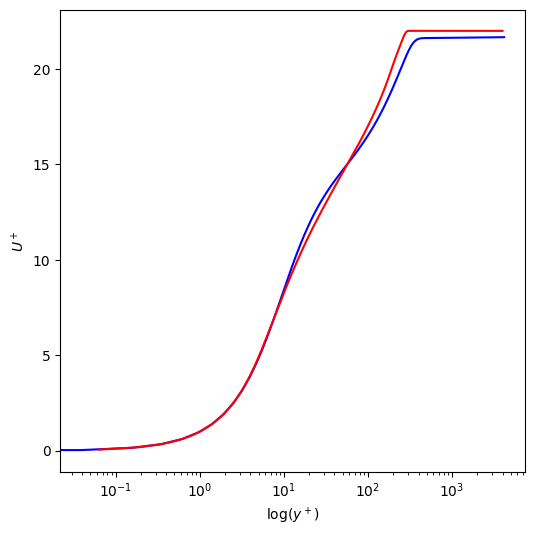

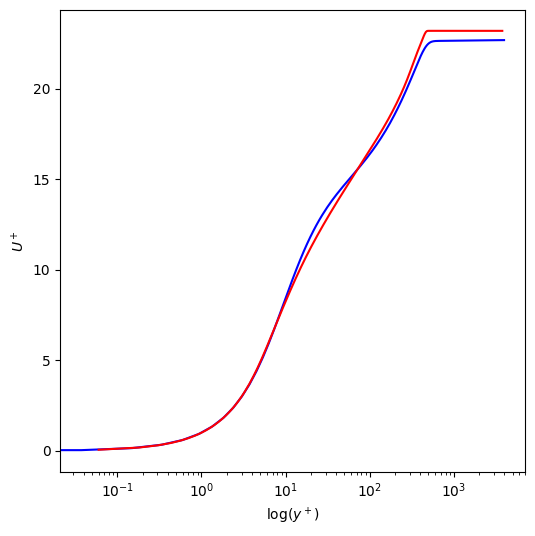

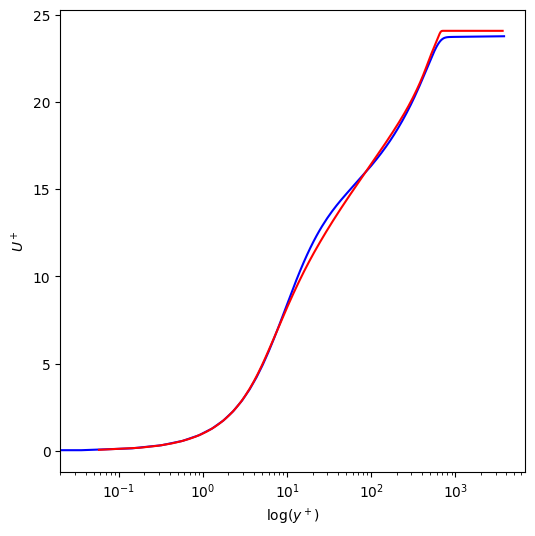

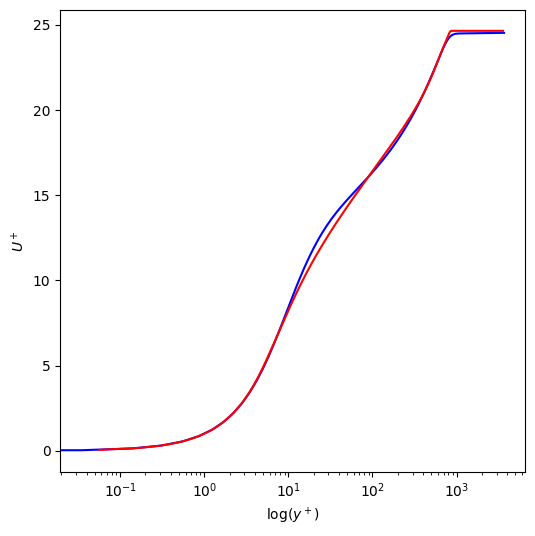

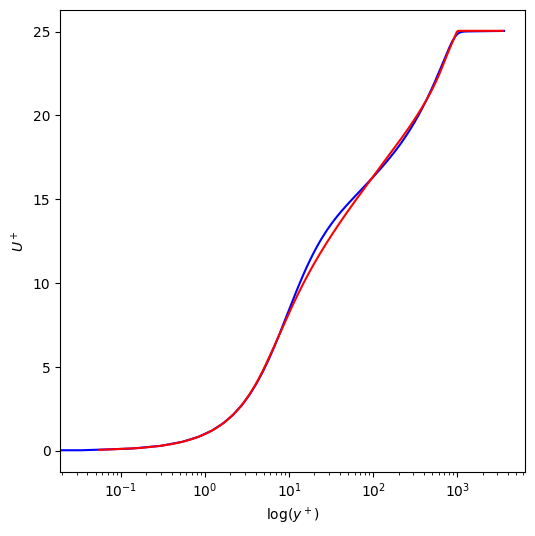

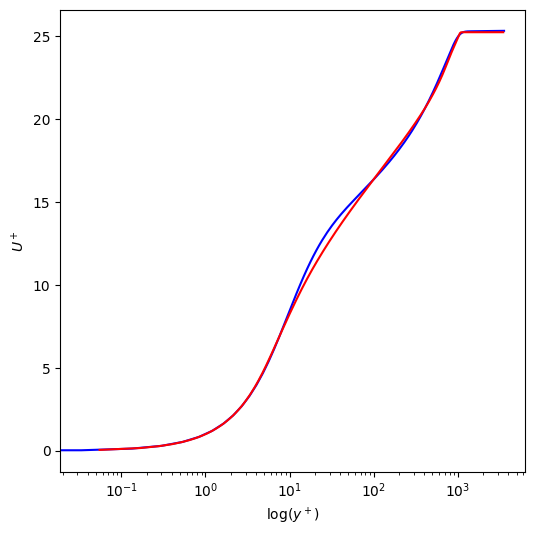

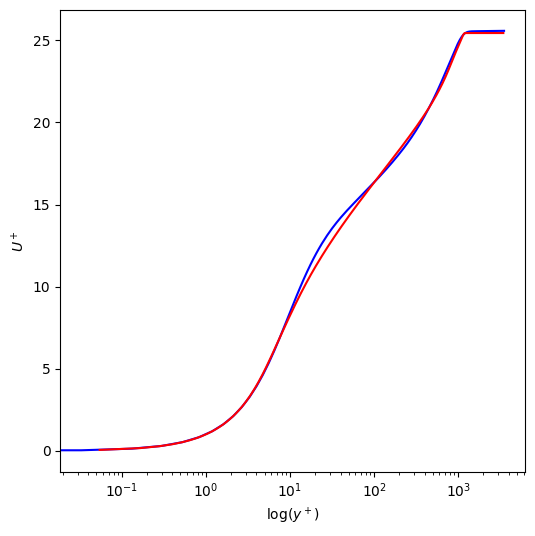

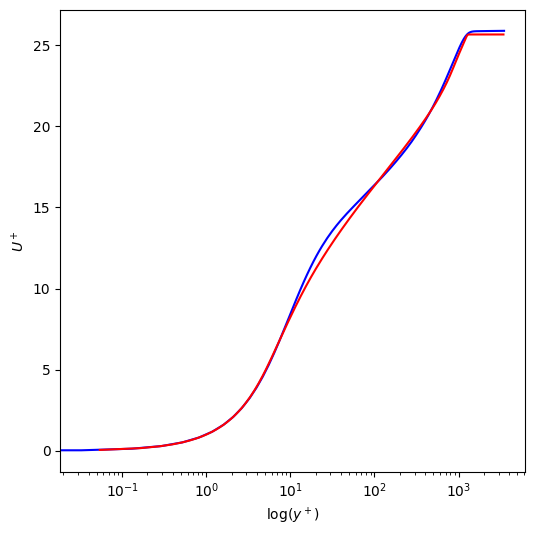

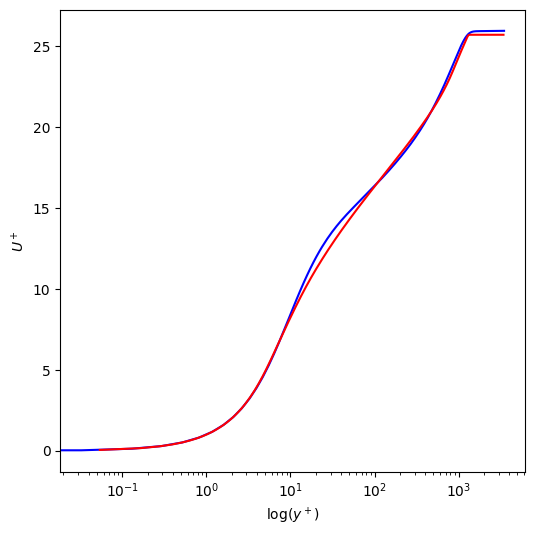

In [241]:
import numpy as np
import Ofpp
import os
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
RANS_foam_folder = '/home/ryley/WDK/ML/scratch/flatplate/'
RANS_numpy_folder = '/home/ryley/WDK/ML/dataset/numpy/komegasst'
DNS_orig_folder = '/home/ryley/WDK/ML/dataset/kth_flatplate/data/'
DNS_numpy_folder = '/home/ryley/WDK/ML/dataset/numpy/DNS'

nu = 1.388e-05
U_infty = 69.4*0.99
interp_method = 'linear'
rans_field_list = ['k',
                    'omega',
                    'epsilon',
                    'T_t_ke',
                    'T_t_nut',
                    'T_k',
                    'U',
                    'gradp',
                    'gradk',
                    'gradomega',
                    'p',
                    'DUDt',
                    'wallDistance',
                    'nut',
                    'S',
                    'Shat',
                    'R',
                    'Rhat',
                    'Ap',
                    'Ak',
                    'Aphat',
                    'Akhat',
                    'gradU',
                    'skewness',
                    'C'
                    ]

def assemble_rans_field_list(rans_field_list):
    for i in range(47):
        rans_field_list.append(f'I1_{i+1}')
        rans_field_list.append(f'I2_{i+1}')
    for i in range(10):
        rans_field_list.append(f'T{i+1}')
    for i in range(9):
        rans_field_list.append(f'q{i+1}')
    for i in range(5):
        rans_field_list.append(f'lambda{i+1}')
    print('Assembled full foam field list: ')
    print(rans_field_list)
    return rans_field_list

rans_field_list = assemble_rans_field_list(rans_field_list)


DNS_Re_theta_list = ['0670', '1000', '1410', '2000', '2540', '3030', '3270', '3630', '3970', '4060']

theta = np.empty(wss.shape)
Re_theta = np.empty(wss.shape)
Re_tau = np.empty(wss.shape)



def v_line(wall_index):
    ind = np.where(abs(C[:,0] - C_bottom[wall_index])<1E-5)[0]
    return RANS_U[ind,:],C[:,1][ind], ind

def get_ind_wall(Re_theta, Re_theta_match):
    return np.nanargmin(np.abs(Re_theta-Re_theta_match))

def get_ind_volume(ind_wall, C, C_bottom):
    return np.where((abs(C[:,0] - C_bottom[ind_wall])<1E-5) & (abs(C[:,1])<0.0179))[0]

# Loop 1: calculate RANS wall-normalized quantities
C_bottom = Ofpp.parse_boundary_field(os.path.join(RANS_foam_folder,'0','C'))[b'bottomWall'][b'value'][:,0]
C = np.load(os.path.join(RANS_numpy_folder,'komegasst_flatplate_C.npy'))
wss = Ofpp.parse_boundary_field(os.path.join(RANS_foam_folder,'10000','wallShearStress'))[b'bottomWall'][b'value'][:,0]
RANS_U = np.load(os.path.join(RANS_numpy_folder,'komegasst_flatplate_U.npy'))
RANS_k = np.load(os.path.join(RANS_numpy_folder,'komegasst_flatplate_k.npy'))
RANS_y = C[:,1]
RANS_U_plus = np.empty(RANS_U.shape)
RANS_k_plus = np.empty(RANS_k.shape)
RANS_y_plus = np.empty(C[:,1].shape)
utau = np.sqrt(np.abs(wss))

def lagrange_polynomial_derivative(x,fx):
    x0 = np.concatenate(([x[0]],x[0:-2],[x[-3]]))
    x1 = np.concatenate(([x[1]],x[1:-1],[x[-2]]))
    x2 = np.concatenate(([x[2]],x[2:],[x[-1]]))
    fx0 = np.concatenate(([fx[0]],fx[0:-2],[fx[-3]]))
    fx1 = np.concatenate(([fx[1]],fx[1:-1],[fx[-2]]))
    fx2 = np.concatenate(([fx[2]],fx[2:],[fx[-1]]))
    xq = x
    derivative = fx0*(2*xq - x1 - x2)/((x0-x1)*(x0-x2)) + fx1*(2*xq - x0 - x2)/((x1-x0)*(x1-x2)) + fx2*(2*xq - x0 - x1)/((x2-x0)*(x2-x1))
    return derivative

def interpolate(C_fine, field_fine, C_coarse, method=interp_method):
    interp_field = griddata(C_fine,
                            field_fine,
                            C_coarse,
                            method=interp_method)

    if interp_method != 'nearest':
        ind_nan = np.argwhere(np.isnan(interp_field))
        if len(ind_nan) >0:
            print('Interpolation found '+ str(len(ind_nan))+' nans, using nearest to fill these nans in')
        interp_field[ind_nan] = griddata(C_fine,
                                         field_fine,
                                         C_coarse[ind_nan], method='nearest')
    return interp_field
                
print(RANS_U.shape)
for i_wall, x_wall in enumerate(C_bottom):
    utau_i = utau[i_wall]
    v_U, v_y, v_ind = v_line(i_wall)
    RANS_U_plus[v_ind] = np.divide(v_U,utau_i)
    RANS_y_plus[v_ind] = np.divide(utau_i*v_y,nu)
    RANS_k_plus[v_ind] = np.divide(RANS_k[v_ind],np.square(utau_i))
    U_inf_i = np.mean(v_U[-65:,0])
    v_U_Uinf = v_U[:,0]/U_inf_i
    theta[i_wall] = np.sum((v_y[1:]-v_y[0:-1])*(v_U_Uinf[0:-1]*(1-v_U_Uinf[0:-1])+v_U_Uinf[1:]*(1-v_U_Uinf[1:]))/2)
    Re_theta[i_wall] = np.divide(U_inf_i*theta[i_wall],nu)
    Re_tau[i_wall] = np.sqrt(np.abs(wss_i))*1/nu
    
for Re_theta_i in DNS_Re_theta_list:
    print(f'Case: {Re_theta_i}')
    ind_wall = get_ind_wall(Re_theta, float(Re_theta_i))
    ind_vol = get_ind_volume(ind_wall, C, C_bottom)
    utau_i = utau[ind_wall]
    DNS_data = np.genfromtxt(f'/home/ryley/WDK/ML/dataset/kth_flatplate/data/vel_{Re_theta_i}_dns.prof',skip_header=14)
    DNS_U_plus = np.column_stack((DNS_data[:,2],DNS_data[:,13],np.zeros(len(DNS_data))))
    DNS_y_plus = DNS_data[:,1]
    DNS_tau_plus = np.zeros((len(DNS_data),3,3))
    DNS_tau_plus[:,0,0] = np.square(DNS_data[:,3])
    DNS_tau_plus[:,1,1] = np.square(DNS_data[:,4])
    DNS_tau_plus[:,2,2] = np.square(DNS_data[:,5])
    DNS_tau_plus[:,0,1] = DNS_data[:,6]
    DNS_tau_plus[:,1,0] = DNS_tau_plus[:,0,1]
    
    DNS_U = DNS_U_plus*utau_i
    DNS_y = DNS_y_plus*nu/utau_i
    DNS_tau = DNS_tau_plus*np.square(utau_i)
    
    DNS_dUdy = lagrange_polynomial_derivative(DNS_y,DNS_U[:,0]) 
    DNS_dVdy = lagrange_polynomial_derivative(DNS_y,DNS_U[:,1]) 
    DNS_dUdx = -DNS_dVdy
    DNS_gradU = np.zeros((len(DNS_data),3,3))
    DNS_gradU[:,0,0] = DNS_dUdx
    DNS_gradU[:,0,1] = DNS_dUdy
    DNS_gradU[:,1,1] = DNS_dVdy
    
    # Interpolate to RANS first to avoid divide by zero (the remainder are all algebraic operations)
    print('Interpolating fields using method '+interp_method)
    C_coarse = C[ind_vol,1]
    C_fine = DNS_y
    print('Fine field: '+str(len(C_fine))+ ' points')
    print('Coarse field: '+str(len(C_coarse))+ ' points')

    DNS_U = interpolate(C_fine,DNS_U,C_coarse,method=interp_method)
    DNS_tau = interpolate(C_fine,DNS_tau,C_coarse,method=interp_method)
    DNS_gradU = interpolate(C_fine,DNS_gradU,C_coarse,method=interp_method)

    # Calculating extra DNS fields
    DNS_k = 0.5*np.trace(DNS_tau,axis1=1,axis2=2)
    DNS_a = DNS_tau - 2/3 * DNS_k[:,None,None] * np.identity(3)
    DNS_b = DNS_a/(2*DNS_k[:,None,None])
    DNS_S = 0.5*(DNS_gradU + np.transpose(DNS_gradU,(0,2,1)))
    DNS_R = 0.5*(DNS_gradU - np.transpose(DNS_gradU,(0,2,1)))
    C_save = np.column_stack((np.zeros(len(C_coarse)),C_coarse,np.zeros(len(C_coarse))))
    # Saving DNS fields
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_a.npy'), DNS_a)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_b.npy'), DNS_b)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_C.npy'), DNS_C)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_gradU.npy'), DNS_gradU)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_k.npy'), DNS_k)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_R.npy'), DNS_R)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_S.npy'), DNS_S)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_TauDNS.npy'), DNS_tau)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_U.npy'), DNS_U)
    
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_yplus.npy'), DNS_y_plus)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_Uplus.npy'), DNS_U_plus)
    np.save(os.path.join(DNS_numpy_folder,f'DNS_fp_{Re_theta_i}_tauplus.npy'), DNS_tau_plus)

    print('Saving RANS fields....')
    for rans_field in rans_field_list:
        field = np.load(os.path.join(RANS_numpy_folder,f'komegasst_flatplate_{rans_field}.npy'))[ind_vol]
        np.save(os.path.join(RANS_numpy_folder,f'komegasst_fp_{Re_theta_i}_{rans_field}.npy'), field)
    np.save(os.path.join(RANS_numpy_folder,f'komegasst_fp_{Re_theta_i}_C.npy'), C_save)
    np.save(os.path.join(RANS_numpy_folder,f'komegasst_fp_{Re_theta_i}_yplus.npy'), RANS_y_plus[ind_vol])
    np.save(os.path.join(RANS_numpy_folder,f'komegasst_fp_{Re_theta_i}_Uplus.npy'), RANS_U_plus[ind_vol])
    np.save(os.path.join(RANS_numpy_folder,f'komegasst_fp_{Re_theta_i}_kplus.npy'), RANS_k_plus[ind_vol])
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.plot(DNS_y_plus,DNS_U_plus[:,0],'b',label='SST')
    ax.plot(RANS_y_plus[ind_vol],RANS_U_plus[ind_vol][:,0],'r',label='DNS')
    ax.semilogx()
    ax.set_ylabel('$U^+$')
    ax.set_xlabel('log($y^+$)')
    fig.savefig(os.path.join(RANS_numpy_folder,f'uplus_yplus_fp_{Re_theta_i}.png'),dpi=300)



(600000,)
-4.000020000006771
-6.000000000349246
600000
600000


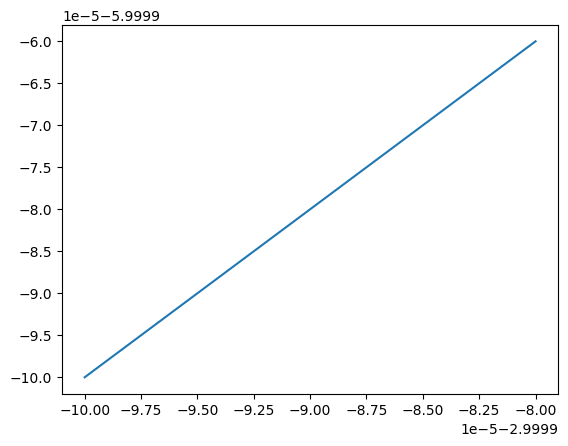

In [181]:
step_size = 0.00001
x = np.arange(-3,3,step_size)
fx = np.square(x)
xi, dxi = lagrange_polynomial_derivative(x,fx)
print(dxi[int(1/step_size)])
print(dxi[0])

print(len(x))
print(len(xi))
#plt.plot(x,fx)
plt.plot(xi[0:3],dxi[0:3])
#plt.xlim([-3.0001,-2.9909])

(513,)
0.0
600000
513


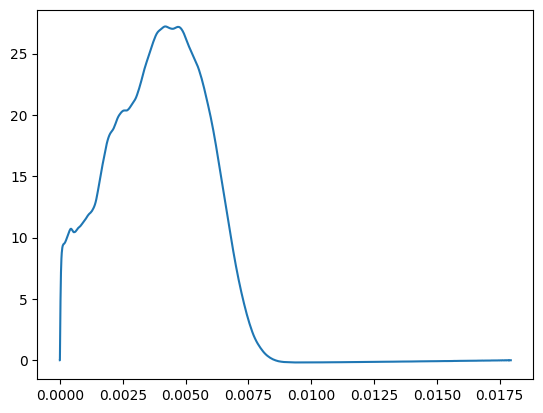

In [186]:
#step_size = 0.00001
xi, dxi = lagrange_polynomial_derivative(DNS_y,DNS_U[:,1])
#print(dxi[int(1/step_size)])
print(dxi[0])

print(len(x))
print(len(xi))
#plt.plot(x,fx)
#plt.plot(xi[0:5],dxi[0:5])
plt.plot(xi,dxi)

#plt.xlim([-3.0001,-2.9909])

0.053717707767995414


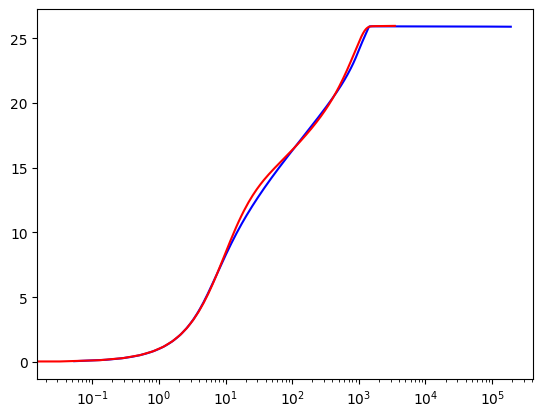

In [62]:
#Re_theta_match = 4061.378
#ind_wall = np.nanargmin(np.abs(Re_theta-Re_theta_match))
#ind = v_line(ind_wall)[2]
ind = get_ind_volume(get_ind_wall(Re_theta, 4060),C,C_bottom)
#print(Re_tau[ind_wall])
#print(np.nanargmin(np.abs(Re_theta-Re_theta_match)))
plt.plot(RANS_y_plus[ind],RANS_U_plus[ind,0],'b')
plt.plot(DNS_y_plus,DNS_U_plus[:,0],c='r')
plt.semilogx()
#plt.xlim([0,5E3])

print(RANS_y_plus[ind][0])

0.053717707767995414
0.01794121861518048


/tmp/ipykernel_7841/160469041.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,5E3])


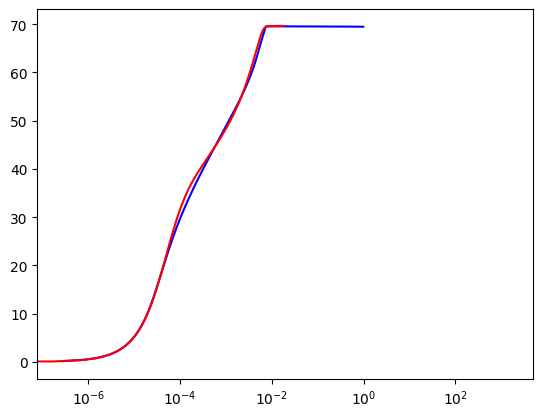

In [63]:
#Re_theta_match = 4061.378
#ind_wall = np.nanargmin(np.abs(Re_theta-Re_theta_match))
#ind = v_line(ind_wall)[2]
ind = get_ind_volume(get_ind_wall(Re_theta, 4060),C,C_bottom)
#print(Re_tau[ind_wall])
#print(np.nanargmin(np.abs(Re_theta-Re_theta_match)))
plt.plot(RANS_y[ind],RANS_U[ind,0],'b')
plt.plot(DNS_y,DNS_U[:,0],c='r')
plt.semilogx()
plt.xlim([0,5E3])

print(RANS_y_plus[ind][0])
print(max(DNS_y))